In [7]:
# !pip install prophet

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from prophet import Prophet

00:36:50 - cmdstanpy - INFO - Chain [1] start processing
00:36:50 - cmdstanpy - INFO - Chain [1] done processing


Columns in dataset: Index(['pickup_datetime', 'pickup_location_id'], dtype='object')
Best Prophet Model MAE: 46.3519
Forecasted Values:
                     ds       yhat  yhat_lower  yhat_upper
744 2023-02-01 00:00:00  44.174660  -31.991780  124.657594
745 2023-02-01 01:00:00  34.544700  -46.439761  105.285162
746 2023-02-01 02:00:00  50.656193  -24.765322  126.256375
747 2023-02-01 03:00:00  78.118516   -4.320293  157.052089
748 2023-02-01 04:00:00  85.373456    8.847016  158.510162
749 2023-02-01 05:00:00  55.602730  -22.912888  127.909050
750 2023-02-01 06:00:00   7.309613  -63.692075   83.840151
751 2023-02-01 07:00:00 -18.694032  -95.063451   54.353458
752 2023-02-01 08:00:00   4.269896  -71.759219   80.859873
753 2023-02-01 09:00:00  62.875183  -13.229232  132.858424


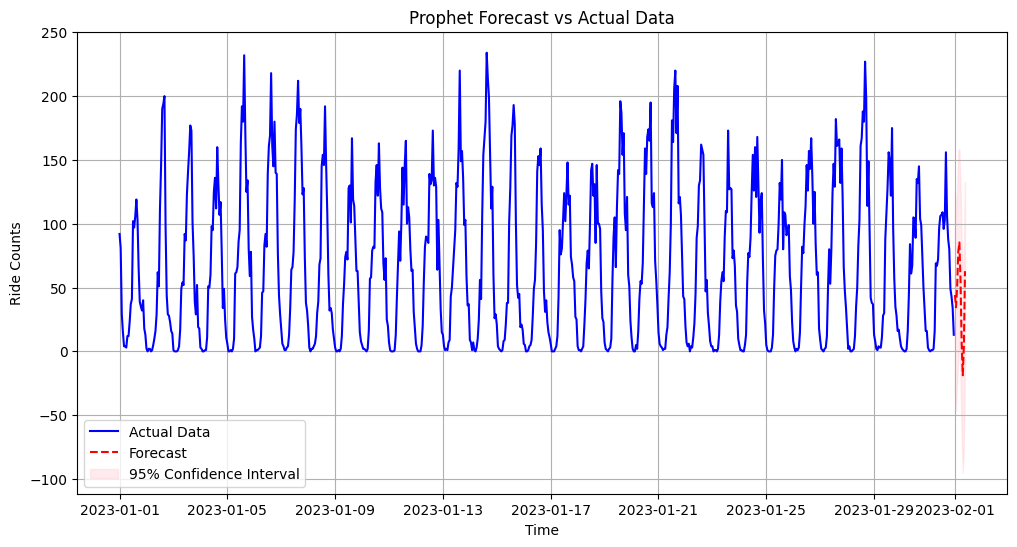

In [11]:


# Load time series data from a Parquet file
def load_data(parquet_path):
    """Loads time series data from a Parquet file."""
    df = pd.read_parquet(parquet_path, engine='pyarrow')
    print("Columns in dataset:", df.columns)  # Debugging: Print available columns
    return df

# Preprocess data
def preprocess_data(df, location_id=43):
    """Filters data for a specific location and ensures a time series format."""
    if "pickup_datetime" not in df.columns:
        raise KeyError("Column 'pickup_datetime' not found in dataset. Available columns: " + str(df.columns))
    
    df["pickup_hour"] = pd.to_datetime(df["pickup_datetime"]).dt.floor("h")  # Convert datetime to hourly
    df = df[df["pickup_location_id"] == location_id]
    df = df.sort_values("pickup_hour")
    df = df.set_index("pickup_hour")
    
    # Resample to ensure all hourly timestamps are present, filling missing values with 0
    ts_data = df["pickup_location_id"].resample("H").count().reset_index()
    ts_data.columns = ["ds", "y"]  # Prophet requires columns named 'ds' and 'y'
    
    return ts_data

# Fit Prophet model
def fit_prophet_model(ts_data):
    """Fits a Prophet model to the time series data."""
    model = Prophet()
    model.fit(ts_data)
    return model

# Forecast future values
def forecast_prophet_model(model, ts_data, steps=10):
    """Generates forecasts using the fitted Prophet model."""
    future = model.make_future_dataframe(periods=steps, freq='H')
    forecast = model.predict(future)
    return forecast.tail(steps)[["ds", "yhat", "yhat_lower", "yhat_upper"]]

# Calculate MAE
def calculate_mae(actual, forecasted):
    """Calculates the Mean Absolute Error (MAE) between actual and forecasted values."""
    return mean_absolute_error(actual, forecasted)

# Plot actual and forecasted values
def plot_forecast(ts_data, forecast):
    """Plots actual data and forecasted values with confidence intervals."""
    plt.figure(figsize=(12, 6))
    plt.plot(ts_data["ds"], ts_data["y"], label="Actual Data", color='blue')
    plt.plot(forecast["ds"], forecast["yhat"], label="Forecast", linestyle='dashed', color='red')
    plt.fill_between(forecast["ds"], forecast["yhat_lower"], forecast["yhat_upper"], color='pink', alpha=0.3, label="95% Confidence Interval")
    plt.xlabel("Time")
    plt.ylabel("Ride Counts")
    plt.title("Prophet Forecast vs Actual Data")
    plt.legend()
    plt.grid()
    plt.show()

if __name__ == "__main__":
    # Define file path
    parquet_file_path = "/Users/sree/Documents/CDA/Project_1/sp25_taxi-main/data/processed"  # Update with actual path
    
    # Load and preprocess data
    try:
        ts_df = load_data(parquet_file_path)
        ts_series = preprocess_data(ts_df)
    
        # Fit Prophet model
        prophet_model = fit_prophet_model(ts_series)
    
        # Forecast the next 10 time steps
        forecast_values = forecast_prophet_model(prophet_model, ts_series, steps=10)
    
        # Calculate and print MAE
        mae = calculate_mae(ts_series["y"].tail(10), forecast_values["yhat"])
        print(f"Best Prophet Model MAE: {mae:.4f}")
    
        # Print forecasts
        print("Forecasted Values:")
        print(forecast_values)
    
        # Plot actual vs forecasted values
        plot_forecast(ts_series, forecast_values)
    
    except Exception as e:
        print(f"Error: {e}")
